In [1]:
import jax
import jax.numpy as jnp

import shutup
shutup.please()

import numpy as np
import ott
from ott.neural.methods.expectile_neural_dual import ExpectileNeuralDual

import flax
import flax.linen as nn
from ott.neural.networks.potentials import MLP
import optax

import matplotlib.pyplot as plt
import os
os.environ['CUDA_VISIBLE_DEVICES']='1'
# 3D rendering
import mitsuba as mi
mi.set_variant('scalar_rgb')

In [2]:
def pad_pointclouds(point_clouds, max_shape=-1):
    if max_shape == -1:
        max_shape = np.max([pc.shape[0] for pc in point_clouds]) + 1
    else:
        max_shape = max_shape + 1
    point_clouds_pad = np.asarray(
        [
            np.concatenate(
                [pc, np.zeros([max_shape - pc.shape[0], pc.shape[-1]])], axis=0
            )
            for pc in point_clouds
        ]
    )
    return point_clouds_pad[:, :-1].astype("float32")

def scale_pointclouds(pc):
    point_cloud = (2 * (pc - pc.min(keepdims=True)) / (pc.max(keepdims=True) - pc.min(keepdims=True)) - 1)
    return point_cloud

path = "/home/m_bobrin/ENOTWEB/Shapenetcore_benchmark/shapenetcore_partanno_segmentation_benchmark_v0_normal/02958343/"
planes = os.listdir(path)#os.listdir("/home/m_bobrin/ENOTWEB/Shapenetcore_benchmark/03261776/points")[:40]
images = []
for img in planes:
    cur_img = np.load(path + img, allow_pickle=True)['pc'] # for npz
    images.append(cur_img)

images = jax.vmap(scale_pointclouds, in_axes=0)(pad_pointclouds(images))
# np.save('planes.npy', arr=images)

In [3]:
# car = np.load("/home/m_bobrin/ENOTWEB/Shapenetcore_benchmark/shapenetcore_partanno_segmentation_benchmark_v0_normal/02958343/b9c0f9dbfb5a1c0f99684c8184952917_8x8.npz")['pc']
# fig = plt.figure(figsize=(20, 20)) 
# ax = fig.add_subplot(4, 4, 1, projection='3d')
# #i = np.random.randint(len(images))
# ax.scatter(car[:, 0], car[:, 2], car[:, 1])
# plt.axis('equal')
# plt.show()

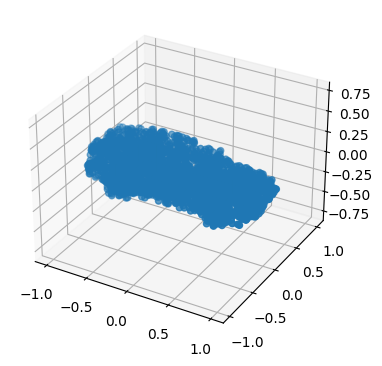

In [4]:
fig = plt.figure(figsize=(20, 20)) 
i = np.random.randint(len(images))
for ind in range(1):
    ax = fig.add_subplot(4, 4, 1+ind, projection='3d')
    #i = np.random.randint(len(images))
    ax.scatter((images)[i][:, 0], (images)[i][:, 2], (images)[i][:, 1])
    plt.axis('equal')
plt.show()

In [5]:
print(i)

564


In [6]:
#np.save("car.npy", arr=images[i])

In [7]:
def normal(size, key = jax.random.key(0)):
    minval = -1
    maxval = 1
    subkey, key = jax.random.split(key)
    noise_samples = jax.random.truncated_normal(subkey, shape = (size, 3), upper = 3, lower = -3)
    noise_samples = minval + (maxval - minval) * (noise_samples + 3) / 6
    return noise_samples

In [8]:
from functools import partial
from dataclasses import dataclass
from typing import Iterator

key = jax.random.PRNGKey(42)
#idx = jax.random.choice(key=key, a=len(images), shape=(1, )).item()
idx = i
#plane = jnp.asarray(images[idx])
plane = jnp.asarray(np.load("/home/m_bobrin/ENOTWEB/car.npy"))

mean_sample = jnp.mean(plane, axis=0)
std_sample = jnp.std(plane, axis=0)

class PlanesDataset:
    def __init__(self, batch_size):
        self.batch_size = batch_size

    def __iter__(self):
        rng = jax.random.PRNGKey(0)
        while True:
            rng, sample_key = jax.random.split(rng, 2)
            yield PlanesDataset._sample(sample_key, self.batch_size)

    @staticmethod
    @partial(jax.jit, static_argnums=(1,))
    def _sample(key, batch_size):
        indx = jax.random.choice(key, a=plane.shape[0], replace=False, shape=(batch_size, ))
        #indx = jax.random.randint(key, (batch_size,), 0, plane.shape[0])
        return plane[indx]

class NoiseDataset:
    def __init__(self, batch_size, std, mean):
        self.batch_size = batch_size
        self.std_sample = std
        self.mean_sample = mean
        
    def __iter__(self):
        rng = jax.random.PRNGKey(0)
        while True:
            rng, sample_key = jax.random.split(rng, 2)
            yield NoiseDataset._sample(sample_key, self.batch_size, std_sample, mean_sample)

    @staticmethod
    @partial(jax.jit, static_argnums=(1,))
    def _sample(key, batch_size, std_sample, mean_sample):
        return jax.random.normal(key, (batch_size, 3)) * std_sample + mean_sample
        #return normal(batch_size, key=key)# * std_sample + mean_sample
    
@dataclass
class TrainLoader:
    src_loader: Iterator[jnp.ndarray]
    tgt_loader: Iterator[jnp.ndarray]
    
fm_dataset_loader = TrainLoader(iter(NoiseDataset(1024, std=std_sample, mean=mean_sample)), iter(PlanesDataset(1024)))

(-1.0996717393398285,
 1.0931065261363984,
 -1.1037194311618805,
 1.0890588343143464)

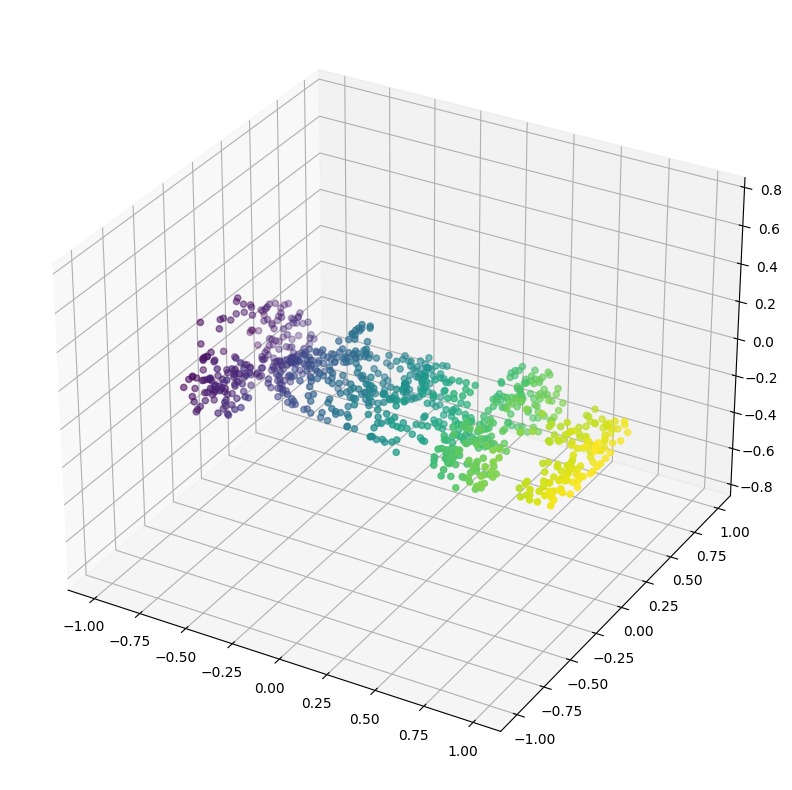

In [9]:
fig = plt.figure(figsize=(10, 10))
img = next(fm_dataset_loader.tgt_loader)

ax = fig.add_subplot(projection='3d')
ax.scatter(img[:, 0], img[:, 2], img[:, 1],
            c=img[:, 0], cmap='viridis')
plt.axis('equal')

## Flow Matching from OTT

In [11]:
from ott.neural.methods.flows import otfm
from ott.neural.networks import velocity_field
from ott.neural.methods.flows.dynamics import StraightFlow, ConstantNoiseFlow, BrownianBridge
from dataclasses import dataclass
from ott.solvers import utils as solver_utils

@dataclass
class FMott:
    source_ds: NoiseDataset
    target_ds: PlanesDataset
    batch_size: int
    mean_sample: jnp.ndarray
    std_sample: jnp.ndarray
    
    def __iter__(self):
        rng = jax.random.PRNGKey(0)
        while True:
            rng, sample_key_src, sample_key_tgt = jax.random.split(rng, 3)
            src_lin = self.source_ds._sample(sample_key_src, self.batch_size, self.std_sample, self.mean_sample)
            tgt_lin = self.target_ds._sample(sample_key_tgt, self.batch_size)
            yield {"src_lin": src_lin, "tgt_lin": tgt_lin}

vf = velocity_field.VelocityField(
    hidden_dims=[256, 256, 256, 256],
    output_dims=[3],
    act_fn=nn.relu
)

fm_net = otfm.OTFlowMatching(
    vf=vf,
    flow=ConstantNoiseFlow(0.01), #BrownianBridge(0.01),
    rng=key,
    match_fn=jax.jit(solver_utils.match_linear),
    optimizer=optax.adam(learning_rate=1e-4)
)
fm_ott_dataset = FMott(source_ds=NoiseDataset, target_ds=PlanesDataset, batch_size=1024, mean_sample=mean_sample, std_sample=std_sample)

(-1.0966464519500732,
 1.0998403072357177,
 -1.1055736780166625,
 1.0909130811691283)

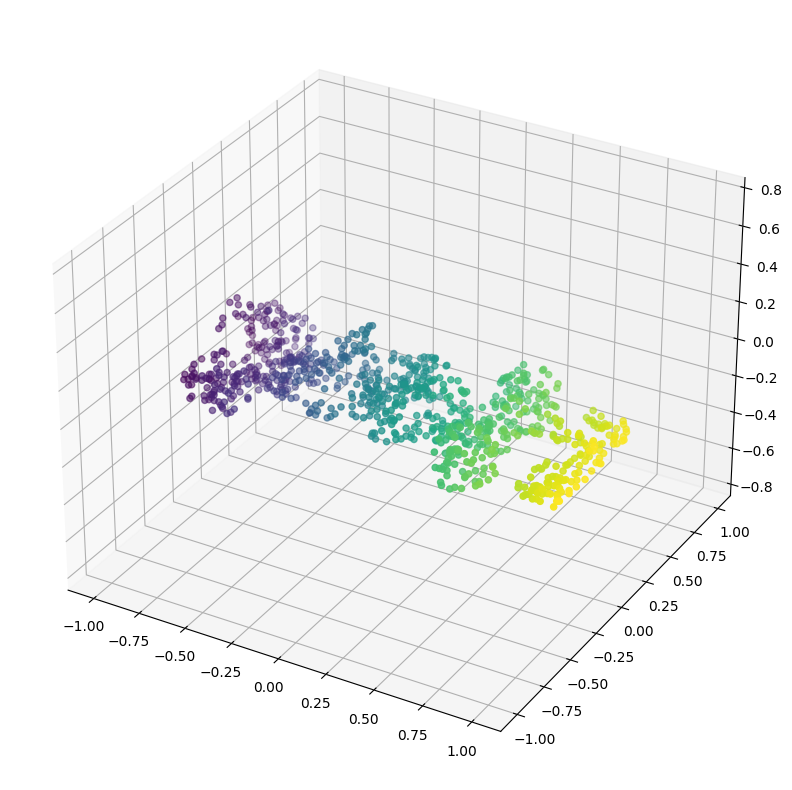

In [12]:
fig = plt.figure(figsize=(10, 10))
img = next(iter(fm_ott_dataset))['tgt_lin']

ax = fig.add_subplot(projection='3d')
ax.scatter(img[:, 0], img[:, 2], img[:, 1],
            c=img[:, 0], cmap='viridis')
plt.axis('equal')

  0%|          | 0/6000 [00:00<?, ?it/s]

(-1.3120601177215574,
 1.3950655460357664,
 -1.3570849150419233,
 1.3500407487154005)

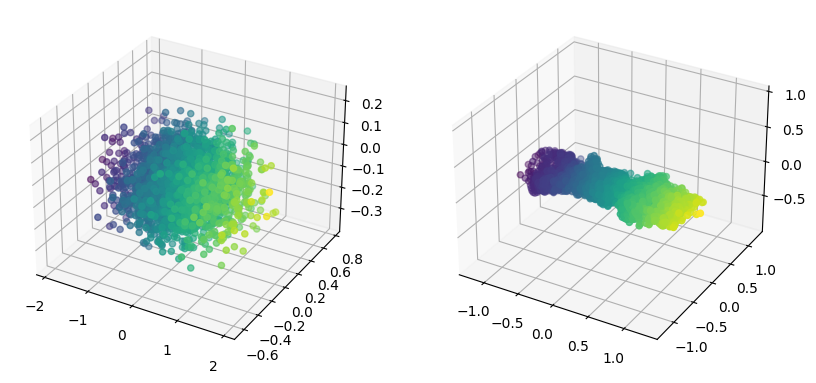

In [13]:
logs = fm_net(iter(fm_ott_dataset), n_iters=6_000)

source_test = NoiseDataset._sample(jax.random.PRNGKey(42), plane.shape[0], std_sample, mean_sample)
pred = fm_net.transport(source_test)

fig = plt.figure(figsize=(10, 5))

ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax1.scatter(source_test[:, 0], source_test[:, 2], source_test[:, 1],
            c=source_test[:, 0], cmap='viridis')
ax2.scatter(pred[:, 0], pred[:, 2], pred[:, 1],
            c=pred[:, 0], cmap='viridis')
plt.axis('equal')

In [14]:
np.save("car_ot-fm.npy", arr=pred)

In [65]:
import imageio

ot_fm_pred = imageio.imread('chair.exr')
imageio.imwrite('chair.png', ot_fm_pred)

## ENOT

(-1.099560844898224,
 1.0907777428627015,
 -1.1027878999710083,
 1.087550687789917)

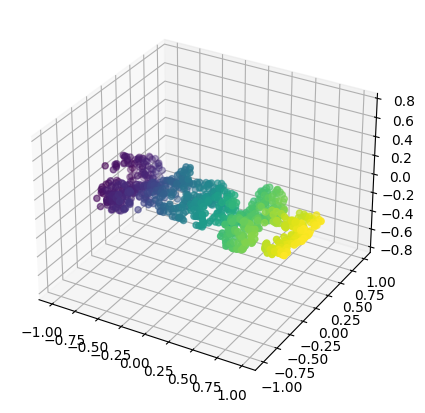

In [36]:
neural_f = MLP(dim_hidden=[256, 256, 256, 256, 3], act_fn=jax.nn.relu)
neural_g = MLP(dim_hidden=[256, 256, 256, 256, 1], act_fn=jax.nn.relu)

enot = ExpectileNeuralDual(
    dim_data=3,
    neural_f=neural_f,
    neural_g=neural_g,
    is_bidirectional=False,
    optimizer_f=optax.adam(learning_rate=1e-4, b1=0.9, b2=0.9),
    optimizer_g=optax.adam(learning_rate=1e-4, b1=0.9, b2=0.9),
    num_train_iters=250_000,
    logging=True,
)

fig = plt.figure(figsize=(5, 5))
img = next(fm_dataset_loader.tgt_loader)

ax = fig.add_subplot(projection='3d')
ax.scatter(img[:, 0], img[:, 2], img[:, 1],
            c=img[:, 0], cmap='viridis')
plt.axis('equal')

In [37]:
potentials, logs = enot(trainloader_source=fm_dataset_loader.src_loader, trainloader_target=fm_dataset_loader.tgt_loader,
     validloader_source=fm_dataset_loader.src_loader, validloader_target=fm_dataset_loader.tgt_loader)

  0%|          | 0/250000 [00:00<?, ?it/s]

(-1.0806105107069015,
 1.1165929406881332,
 -1.105766412615776,
 1.0914370387792587)

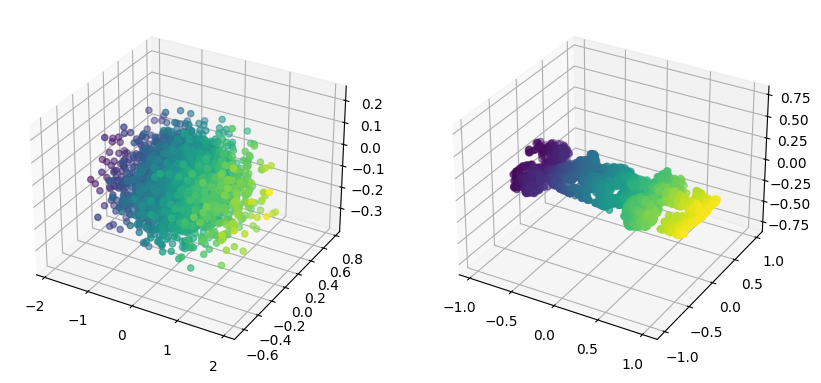

In [38]:
source_test = NoiseDataset._sample(jax.random.PRNGKey(42), plane.shape[0], std_sample, mean_sample)
pred = potentials.transport(source_test)

fig = plt.figure(figsize=(10, 5))

ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax1.scatter(source_test[:, 0], source_test[:, 2], source_test[:, 1],
            c=source_test[:, 0], cmap='viridis')
ax2.scatter(pred[:, 0], pred[:, 2], pred[:, 1],
            c=pred[:, 0], cmap='viridis')
plt.axis('equal')

In [39]:
np.save("car_enot.npy", arr=pred)

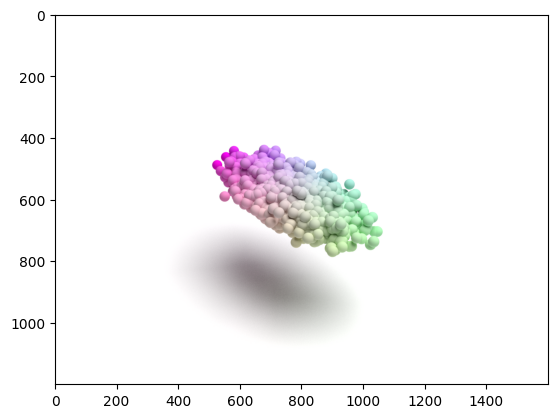

In [31]:
#np.save("amos_chair.npy", arr=pred)
# AFTER MITSUBA RENDERING AND POINTFLOW_FIG_COLORFUL.PY
import imageio
import matplotlib.pyplot as plt
from PIL import Image

#pointcloud_image = (imageio.imread('/home/m_bobrin/ENOTWEB/PointFlowRenderer/Anim/images/frame_001.png'))
#pointcloud_image = Image.open('/home/m_bobrin/ENOTWEB/PointFlowRenderer/Anim/images/frame_001.png').convert("RGBA")
#plt.imshow(pointcloud_image)
#imageio.imwrite('test.png', pointcloud_image, quality=100)

In [4]:
import glob
from PIL import Image

def make_gif(frame_folder):
    frames = [Image.open(image) for image in glob.glob(f"{frame_folder}/*.png")]
    frame_one = frames[0]
    frame_one.save(frame_folder + "/my_awesome.gif", format="GIF", append_images=frames,
               save_all=True, duration=300, loop=1, optimize=False)
make_gif("/home/m_bobrin/ENOTWEB/rotation_car/images")

In [104]:
# np.save(arr=source_test, file='noise')
#np.save(arr=pred, file='plane1_enot')

## PLY

In [35]:
import numpy as np
import open3d as o3d

def use_o3d(pts, write_text, name_file: str):
    pcd = o3d.geometry.PointCloud()

    # the method Vector3dVector() will convert numpy array of shape (n, 3) to Open3D format.
    # see http://www.open3d.org/docs/release/python_api/open3d.utility.Vector3dVector.html#open3d.utility.Vector3dVector
    pcd.points = o3d.utility.Vector3dVector(pts)

    # http://www.open3d.org/docs/release/python_api/open3d.io.write_point_cloud.html#open3d.io.write_point_cloud
    o3d.io.write_point_cloud(name_file, pcd, write_ascii=write_text)

    # read ply file
    pcd = o3d.io.read_point_cloud(name_file)

    # visualize
    # o3d.visualization.draw_geometries([pcd])

source_noise = np.load("/home/m_bobrin/ENOTWEB/source_noise.npy")
target = np.load("/home/m_bobrin/ENOTWEB/car.npy")

# whether to write in binary or text format
write_text = True

# use open3d
use_o3d(source_noise, write_text, name_file="source_noise.ply")


In [34]:
source_test = NoiseDataset._sample(jax.random.PRNGKey(42), plane.shape[0], std_sample, mean_sample)
np.save("source_noise.npy", arr=source_test)

## Mitsuba rendering

In [21]:
import mitsuba as mi

mi.set_variant('scalar_rgb')

bmp = mi.Bitmap('enot_plane1.exr')
bmp

Bitmap[
  pixel_format = rgb,
  component_format = float16,
  size = [1600, 1200],
  srgb_gamma = 0,
  struct = Struct<6>[
    float16 R; // @0, premultiplied alpha
    float16 G; // @2, premultiplied alpha
    float16 B; // @4, premultiplied alpha
  ],
  metadata = {
    generatedBy => "Mitsuba version 3.5.2",
    pixelAspectRatio => 1,
    screenWindowWidth => 1
  },
  data = [ 11 MiB of image data ]
]

/tmp/ipykernel_32994/224789737.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  pointcloud_image = imageio.imread('/home/m_bobrin/ENOTWEB/PointFlowRenderer/Anim/images/frame_000.exr')


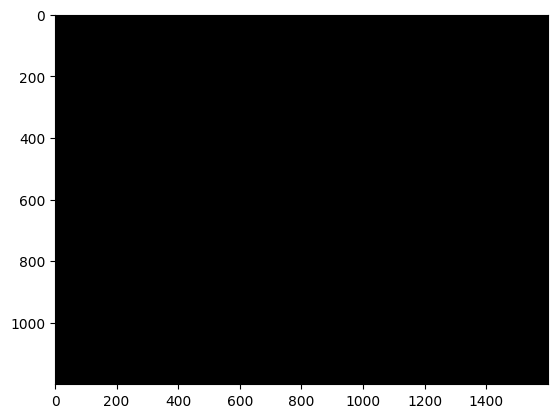

In [6]:
import imageio
import matplotlib.pyplot as plt

pointcloud_image = imageio.imread('/home/m_bobrin/ENOTWEB/PointFlowRenderer/Anim/images/frame_000.exr')
plt.imshow(pointcloud_image)